<a href="https://colab.research.google.com/github/marcexpositg/CRISPRed/blob/master/02.Model/2.6.OutcomesModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.6. Outcomes prediction

The outcome prediction problem was simplified to 8 different categories (7 deletion sizes + 1 insertion of any type). For more details on this simplification, see notebook 2.3. OutcomesProfiling. All groups are in similar proportion in the data set. These are the 8 groups representing all possible outcomes:

- LessEq_2bp
- 3bp_4bp
- 5bp_6bp
- 7bp_8bp
- 9bp_11bp
- 12bp_14bp
- More_15bp
- Insertion

The initial objective was predicting the frequency of each of these outcomes depending on the gRNA sequence. However, multiclass classification with soft labels requires a complex implementation. Hence, the problem is simplified and tackled by planning two different approaches:

- Approach 1: Predict the major outcome.
- Approach 2: Predict the most frequent outcomes.

Approach 1 simplifies the problem by turning it into a multiclass classification problem. While in the original problem multiple classes were possible at different probabilities for the a single sample, in approach 1 each sample has one and only one label (the most frequent outcome) from the 8 possible outcomes, which have been turned into mutually exclusive by predicting "the most frequent one".

Approach 2 gets closer to reality, but simplifies the problem by turning it into a multilabel classification problem. While in the original problem *all* classes are possible at different probabilities, in approach 2 each sample can have multiple labels from the 8 possible, but probabilities are not computed. For that, the outcome probabilities were converted to binary values, so that they are either (present/majoritary or absent/minoritary).

Approach 2 is closer to reality than approach 1 because approach 2 predicts more than one outcome if the probabilities of getting diverse outcomes are high. However, it does not predict the majoritary outcome. Instead, approach 1 only predicts the majoritary outcome but does not provide information on the outcome variability (will one outcome dominate over the others? or will we get a mixed population?). Both of the parameters (diversity and the majoritary) are of interest, so probably both approaches could be combined.

Differences between multiclass and multilabel classification (from [sklearn docs](https://scikit-learn.org/stable/modules/multiclass.html):
- Multiclass classification:
  - Targets (labels): 1
  - Target cardinality (possible labels): >1
- Multilabel classification:
  - Targets (labels): >1
  - Target cardinality (possible labels): 2 (0 or 1)

How are these used into the model?

- To predict the majoritary outcome, we use multiclass classification because we want to predict a single label from more than 1 possible mutually exclusive labels (in total, there are 8 different classes of outcomes and we want to predict just 1, the most frequent).

- To predict diverse outcomes, we use multilabel classification because we want to predict the presence or absence (possible labels=2 (0 or 1)) of multiple labels (8 different classes of outcomes).

**Note:** The script takes very long to execute (>5 mins) because of the optimization in all of the models and the need to predict 8 different classes for each model.

**Summary:**
- Approach 1. One-vs.-rest binary classifiers for each class using:
  - Linear regression
  - SVM
- Approach 2. Multilabel classifiers using Random Forest

**Results:**

All predictors have poor performance and very low predictive value. The causes probably are:

- Grouping so diverse outcomes in just 8 classes breaks the relation between the outcomes and the target sequences.
- Microhomology accounts for most of the deletions, so microhomology features should be added to the model.

To avoid simplifying the problem, soft labels could be predicted using multiclass regression, and ajusting both the input data and the output predictions with a sigmoid function so that the outcomes probabilities are between 0 and 1 and when summed they are up to 1. See the following webistes: [1](https://stackoverflow.com/questions/42800769/scikit-learn-classification-on-soft-labels),[2](https://stats.stackexchange.com/questions/231981/how-do-i-make-use-of-soft-labels-in-binary-classification),[3](https://stackoverflow.com/questions/42800769/scikit-learn-classification-on-soft-labels),[4](https://www.quora.com/How-do-I-make-use-of-%E2%80%9Csoft%E2%80%9D-labels-in-binary-classification),[5](https://www.researchgate.net/post/How_to_train_a_classifier_using_probability_class_labeled_data_in_machine_learning),[6](https://datascience.stackexchange.com/questions/48111/multilabel-classifcation-in-sklearn-with-soft-fuzzy-labels),[7](https://books.google.es/books?id=GtCBDwAAQBAJ&pg=PA64&lpg=PA64&dq=logistic+regression+%22soft+labels%22+sklearn&source=bl&ots=OCk38s7wOv&sig=ACfU3U15sGufhxdjK6fJ_OyxKbOsQuhCcw&hl=en&sa=X&ved=2ahUKEwjD4ta8uJbqAhX76OAKHRb_CCcQ6AEwB3oECAgQAQ#v=onepage&q=logistic%20regression%20%22soft%20labels%22%20sklearn&f=false), [8](https://books.google.es/books?id=M0vODwAAQBAJ&pg=PA107&lpg=PA107&dq=logistic+regression+%22soft+labels%22+sklearn&source=bl&ots=mI2dmgKWTN&sig=ACfU3U0IZgFtOtLBb_hBsHilOAmGeFLXoA&hl=en&sa=X&ved=2ahUKEwjD4ta8uJbqAhX76OAKHRb_CCcQ6AEwBnoECAkQAQ#v=onepage&q=logistic%20regression%20%22soft%20labels%22%20sklearn&f=false).

## 1. Approach 1: Major class

### 1.1. Logistic Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
outcomes_cl = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/02.Model/Labels/outcomes_freq_simp.csv")
outcomes_cl.rename(columns={'Unnamed: 0':'ids'}, inplace=True)
print(outcomes_cl)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            ids  LessEq_2bp  ...  Insertion    MaxClass
0     ENSMUSG00000033788_gR434r    0.080000  ...   0.240000   Insertion
1     ENSMUSG00000033788_gR113f    0.086667  ...   0.053333    9bp_11bp
2      ENSMUSG00000033788_gR70f    0.127333  ...   0.142000    9bp_11bp
3     ENSMUSG00000023020_gR346r    0.146923  ...   0.070769     3bp_4bp
4     ENSMUSG00000023020_gR376r    0.158889  ...   0.031111    9bp_11bp
...                         ...         ...  ...        ...         ...
1717  ENSMUSG00000025791_gR257r    0.349796  ...   0.114694  LessEq_2bp
1718  ENSMUSG00000025791_gR494f    0.094627  ...   0.050746     5bp_6bp
1719  ENSMUSG00000023484_gR261f    0.156923  ...   0.118462     3bp_4bp
1720  ENSMUSG00000023484_gR270f    0.065000  ...   0.035000    9bp_11bp
1721  ENSMUSG00000023484_gR479f    0.111111  ...   0.048444     5bp_6bp

[1722 rows x 10 columns]


In [2]:
outcomes_cl['MaxClass'] = outcomes_cl['MaxClass'].astype('category')
outcomes_cl['MaxClass'].cat.reorder_categories(['LessEq_2bp','3bp_4bp','5bp_6bp',
                                                '7bp_8bp','9bp_11bp','12bp_14bp',
                                                'More_15bp','Insertion'],
                                                inplace=True)
outcomes_names = outcomes_cl['MaxClass'].cat.categories
print(outcomes_cl['MaxClass'])

0        Insertion
1         9bp_11bp
2         9bp_11bp
3          3bp_4bp
4         9bp_11bp
           ...    
1717    LessEq_2bp
1718       5bp_6bp
1719       3bp_4bp
1720      9bp_11bp
1721       5bp_6bp
Name: MaxClass, Length: 1722, dtype: category
Categories (8, object): [LessEq_2bp, 3bp_4bp, 5bp_6bp, 7bp_8bp, 9bp_11bp, 12bp_14bp, More_15bp,
                         Insertion]


In [3]:
features = pd.read_csv("https://raw.githubusercontent.com/marcexpositg/CRISPRed/master/02.Model/Featurization/gRNA_features.csv", header=0)
print(features)

                            ids   A0   C0   G0   T0  ...   A  C   G  T  GC_content
0     ENSMUSG00000033788_gR434r  0.0  0.0  0.0  1.0  ...   5  0  13  2        65.0
1     ENSMUSG00000033788_gR113f  1.0  0.0  0.0  0.0  ...   4  6   5  5        55.0
2      ENSMUSG00000033788_gR70f  0.0  0.0  1.0  0.0  ...   5  5   8  2        65.0
3     ENSMUSG00000023020_gR346r  1.0  0.0  0.0  0.0  ...  10  4   2  4        30.0
4     ENSMUSG00000023020_gR376r  0.0  0.0  0.0  1.0  ...   4  5   5  6        50.0
...                         ...  ...  ...  ...  ...  ...  .. ..  .. ..         ...
1717  ENSMUSG00000025791_gR257r  0.0  0.0  1.0  0.0  ...   7  2   5  6        35.0
1718  ENSMUSG00000025791_gR494f  0.0  0.0  1.0  0.0  ...   8  5   5  2        50.0
1719  ENSMUSG00000023484_gR261f  1.0  0.0  0.0  0.0  ...  10  5   5  0        50.0
1720  ENSMUSG00000023484_gR270f  1.0  0.0  0.0  0.0  ...   6  5   8  1        65.0
1721  ENSMUSG00000023484_gR479f  1.0  0.0  0.0  0.0  ...   4  6   6  4        60.0

[17

In [4]:
# stratify to have same proportion of outcomes in test and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    features.drop(["ids"],axis=1),outcomes_cl['MaxClass'], random_state=0, 
    stratify=outcomes_cl['MaxClass'])

In [5]:
# only the majoritary outcome per each sample is predicted
print("Training set features:   " + str(X_train.shape) + "(Samples,features)")
print("Test set features:       " + str(X_test.shape) +  " (Samples,features)")
print("Training set outcomes:   " + str(y_train.shape) + "    (Samples,labels)")
print("Test set outcomes:       " + str(y_test.shape) +  "     (Samples,labels)")

Training set features:   (1291, 389)(Samples,features)
Test set features:       (431, 389) (Samples,features)
Training set outcomes:   (1291,)    (Samples,labels)
Test set outcomes:       (431,)     (Samples,labels)


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

parameters = {
    'C'             : [0.001,0.01,0.1,1,10,100],
    'penalty'       : ["l1","l2"], 
    'solver'        : ['liblinear'],
    'multi_class'   : ['ovr'] #one vs rest specification
}

lr_cl = GridSearchCV(LogisticRegression(), parameters, cv=5,
                     scoring="accuracy", n_jobs=-1)

In [7]:
lr_cl.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'multi_class': ['ovr'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [8]:
print("Best parameters: {}".format(lr_cl.best_params_))

Best parameters: {'C': 0.1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [9]:
lr_cl.classes_

array(['12bp_14bp', '3bp_4bp', '5bp_6bp', '7bp_8bp', '9bp_11bp',
       'Insertion', 'LessEq_2bp', 'More_15bp'], dtype=object)

In [10]:
# show the first few entries of predict_proba
# it has 8 columns with the probability of each class, 
# are this similar to the probabilities specified before getting the maximum?
print("Predicted probabilities:\n{}".format(lr_cl.predict_proba(X_test)[:6]))

Predicted probabilities:
[[0.04524233 0.28445988 0.11379511 0.07018823 0.0918116  0.0300356
  0.3260012  0.03846607]
 [0.06079511 0.19268945 0.09995318 0.07666477 0.08159745 0.04811503
  0.34417423 0.09601079]
 [0.02031074 0.20035605 0.08682267 0.07034237 0.22630356 0.02470122
  0.31558636 0.05557703]
 [0.02621125 0.17844636 0.16582716 0.06338777 0.1971436  0.03599917
  0.29502229 0.03796239]
 [0.02551285 0.25153947 0.10285203 0.24360784 0.07699297 0.02813432
  0.22623726 0.04512326]
 [0.03400651 0.21605498 0.10752636 0.06870837 0.08438115 0.03967083
  0.41782045 0.03183135]]


In [11]:
# We can get the majoritary outcome taking the argmax
#print("Argmax of predicted probabilities:\n{}".format(np.argmax(lr_cl.predict_proba(X_test), axis=1)))
lr_pred = lr_cl.predict(X_test)
print("Predictions for first 10 test samples:\n{}".format(lr_pred[1:10]))

Predictions for first 10 test samples:
['LessEq_2bp' 'LessEq_2bp' 'LessEq_2bp' '3bp_4bp' 'LessEq_2bp' '7bp_8bp'
 '5bp_6bp' '5bp_6bp' '5bp_6bp']


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
lr_confMat = confusion_matrix(y_test, lr_pred)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, lr_pred)))
print("Confusion matrix:\n{}".format(lr_confMat))

Accuracy: 0.334
Confusion matrix:
[[ 0  0  5  1  3  0 10  0]
 [ 0  4 12 10  8  0 45  0]
 [ 0  3 23  7  7  0 28  0]
 [ 0  1  8 28  4  0 19  0]
 [ 0  5  4  7 26  0 24  0]
 [ 0  1  0  0  2  0 11  0]
 [ 0  6 11 11  8  0 63  0]
 [ 0  5  2  5  2  0 12  0]]


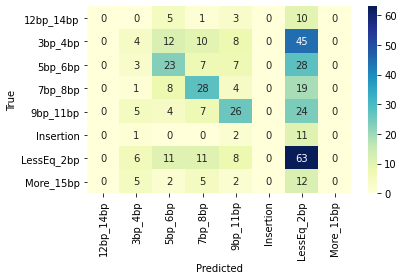

In [13]:
df_cm = pd.DataFrame(lr_confMat, index = lr_cl.classes_,columns = lr_cl.classes_)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("Approach1_LR.png", dpi=600)
plt.show()

In [14]:
print(lr_cl.score(X_test,y_test))

0.33410672853828305


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

   12bp_14bp       0.00      0.00      0.00        19
     3bp_4bp       0.16      0.05      0.08        79
     5bp_6bp       0.35      0.34      0.35        68
     7bp_8bp       0.41      0.47      0.43        60
    9bp_11bp       0.43      0.39      0.41        66
   Insertion       0.00      0.00      0.00        14
  LessEq_2bp       0.30      0.64      0.41        99
   More_15bp       0.00      0.00      0.00        26

    accuracy                           0.33       431
   macro avg       0.21      0.24      0.21       431
weighted avg       0.28      0.33      0.29       431



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.2. SVM

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import f1_score

svm_to_set = OneVsRestClassifier(SVC(kernel="poly"))
parameters = {
    "estimator__C": [1,2,4],
    "estimator__kernel": ["poly","rbf"],
    "estimator__degree":[1, 2],
}
model_tunning = GridSearchCV(svm_to_set, param_grid=parameters, cv=5)#,scoring='f1_weighted')
model_tunning.fit(X_train, y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_)

0.30670737182365093
{'estimator__C': 4, 'estimator__degree': 1, 'estimator__kernel': 'poly'}


In [17]:
svm_pred = model_tunning.predict(X_test)

In [18]:
print("Predictions for first 10 test samples:\n{}".format(svm_pred[1:10]))

Predictions for first 10 test samples:
['3bp_4bp' 'LessEq_2bp' '5bp_6bp' 'LessEq_2bp' 'LessEq_2bp' '7bp_8bp'
 'LessEq_2bp' '7bp_8bp' 'LessEq_2bp']


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
svm_confMat = confusion_matrix(y_test, svm_pred)
print("Accuracy: {:.3f}".format(accuracy_score(y_test, svm_pred)))
print("Confusion matrix:\n{}".format(svm_confMat))

Accuracy: 0.269
Confusion matrix:
[[ 4  0  0  2  4  1  7  1]
 [ 7  4 14 13  8  0 30  3]
 [ 1  5 16  9  9  4 24  0]
 [ 2  2  4 30  6  0 13  3]
 [ 4  6  5 16 19  1 13  2]
 [ 0  1  4  1  2  1  5  0]
 [ 2  8 10 11 19  4 41  4]
 [ 2  2  4  4  5  1  7  1]]


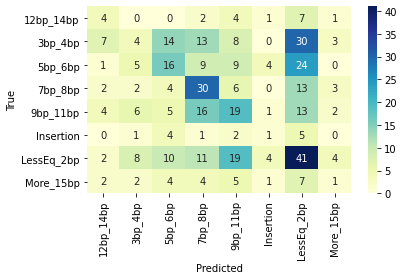

In [20]:
df_cm = pd.DataFrame(svm_confMat, index = model_tunning.classes_,columns = model_tunning.classes_)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("Approach1_SVM.png", dpi=600)
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

   12bp_14bp       0.18      0.21      0.20        19
     3bp_4bp       0.14      0.05      0.07        79
     5bp_6bp       0.28      0.24      0.26        68
     7bp_8bp       0.35      0.50      0.41        60
    9bp_11bp       0.26      0.29      0.28        66
   Insertion       0.08      0.07      0.08        14
  LessEq_2bp       0.29      0.41      0.34        99
   More_15bp       0.07      0.04      0.05        26

    accuracy                           0.27       431
   macro avg       0.21      0.23      0.21       431
weighted avg       0.24      0.27      0.25       431



In [22]:
model_tunning.score(X_test,y_test)

0.2691415313225058

## 2. Approach 2. Outcome diversity

Predict outcome diversity and identity using **multilabel classifiers**.

The first step is applying a threshold of 0.13 to classify the classes as abundant or not abundant.

In [23]:
# create multilabel binary outcomes with a binarizer
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.13)
ml_outc =  binarizer.transform(outcomes_cl.drop(['ids','MaxClass'],axis=1))
ml_outc = pd.DataFrame(ml_outc, index=features['ids'].values, columns=outcomes_cl.drop(['ids','MaxClass'], axis=1).columns)
print(ml_outc)

                           LessEq_2bp  3bp_4bp  ...  More_15bp  Insertion
ENSMUSG00000033788_gR434r         0.0      0.0  ...        0.0        1.0
ENSMUSG00000033788_gR113f         0.0      0.0  ...        1.0        0.0
ENSMUSG00000033788_gR70f          0.0      0.0  ...        0.0        1.0
ENSMUSG00000023020_gR346r         1.0      1.0  ...        0.0        0.0
ENSMUSG00000023020_gR376r         1.0      0.0  ...        0.0        0.0
...                               ...      ...  ...        ...        ...
ENSMUSG00000025791_gR257r         1.0      0.0  ...        0.0        0.0
ENSMUSG00000025791_gR494f         0.0      1.0  ...        0.0        0.0
ENSMUSG00000023484_gR261f         1.0      1.0  ...        0.0        0.0
ENSMUSG00000023484_gR270f         0.0      0.0  ...        0.0        0.0
ENSMUSG00000023484_gR479f         0.0      1.0  ...        0.0        0.0

[1722 rows x 8 columns]


Most of the gRNA have about 3 classes considered abundant, and none above 6 classes. Since relative frequency is used, gRNAs which have less abundant classes have less dispersion of the outcomes, because that class is predominant. gRNAs that have a high number of classes have more dispersion, because more classes are present in a relatively similar and low frequency.

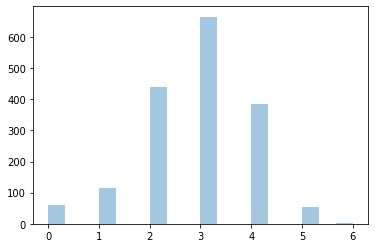

In [24]:
sns.distplot(ml_outc.sum(axis=1), kde=False)
plt.show()

In [25]:
# Split data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features.drop(["ids"],axis=1),ml_outc, random_state=0)

In [26]:
# This is the shape of the features and labels (outcomes)
# In this approach, 8 different outcomes are predicted as abundant/not abundant in the samples.
print("Training set features:   " + str(X_train.shape) + "(Samples,features)")
print("Test set features:       " + str(X_test.shape) +  " (Samples,features)")
print("Training set outcomes:   " + str(y_train.shape) + "  (Samples,labels)")
print("Test set outcomes:       " + str(y_test.shape) +  "   (Samples,labels)")

Training set features:   (1291, 389)(Samples,features)
Test set features:       (431, 389) (Samples,features)
Training set outcomes:   (1291, 8)  (Samples,labels)
Test set outcomes:       (431, 8)   (Samples,labels)


In [27]:
# Random forest is optimized to search for multiple depths and features
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators'      : [250,400,500],
    'max_features'      : [6,10,15,20], 
    'max_depth'         : [10,20,40],
    'random_state'      : [0],
}

rf_cl = GridSearchCV(RandomForestClassifier(), parameters, cv=5,
                     scoring="accuracy", n_jobs=-1)

In [28]:
# Train the model
rf_cl.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [29]:
# The model predicts the probability of having each of the 8 classes abundant (1) or not (0)
rf_cl.classes_

[array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.]),
 array([0., 1.])]

In [30]:
preds = pd.DataFrame(rf_cl.predict(X_test),index=y_test.index ,columns=outcomes_cl.drop(['ids','MaxClass'], axis=1).columns)
preds
# not interested in probability for each class, since the training data was given as binaries.
# These probabilities do not correspond to the frequency of the outcomes, they indicate the likeliness of being abundant or not.
#rf_cl.predict_proba(X_test)

,LessEq_2bp,3bp_4bp,5bp_6bp,7bp_8bp,9bp_11bp,12bp_14bp,More_15bp,Insertion
ENSMUSG00000039533_gR474r,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ENSMUSG00000027889_gR269f,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ENSMUSG00000059363_gR309f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000030654_gR398f,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000042737_gR358f,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
ENSMUSG00000014609_gR148r,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ENSMUSG00000068699_gR248r,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000022982_gR249r,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000039519_gR271f,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
# Just for visual comparision with the predictions... some outcomes are similar and some not.
y_test

,LessEq_2bp,3bp_4bp,5bp_6bp,7bp_8bp,9bp_11bp,12bp_14bp,More_15bp,Insertion
ENSMUSG00000039533_gR474r,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
ENSMUSG00000027889_gR269f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
ENSMUSG00000059363_gR309f,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
ENSMUSG00000030654_gR398f,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ENSMUSG00000042737_gR358f,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
ENSMUSG00000014609_gR148r,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
ENSMUSG00000068699_gR248r,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
ENSMUSG00000022982_gR249r,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
ENSMUSG00000039519_gR271f,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


The performance of the model is assessed by getting the number of outcomes that were correctly predicted for each target region. The distribution of the number of coincidences is shown below.

In [32]:
compare_predTest = (preds == y_test)
compare_predTest['Num_coinc'] = compare_predTest.sum(axis=1)
compare_predTest

,LessEq_2bp,3bp_4bp,5bp_6bp,7bp_8bp,9bp_11bp,12bp_14bp,More_15bp,Insertion,Num_coinc
ENSMUSG00000039533_gR474r,True,False,False,True,True,True,True,True,6
ENSMUSG00000027889_gR269f,False,True,True,True,False,True,True,True,6
ENSMUSG00000059363_gR309f,False,False,True,False,True,True,True,True,5
ENSMUSG00000030654_gR398f,True,True,False,True,True,False,True,True,6
ENSMUSG00000042737_gR358f,True,True,True,True,True,True,False,True,7
...,...,...,...,...,...,...,...,...,...
ENSMUSG00000014609_gR148r,True,True,True,True,False,True,True,True,7
ENSMUSG00000068699_gR248r,True,True,True,False,True,True,True,True,7
ENSMUSG00000022982_gR249r,True,True,True,False,False,True,False,False,4
ENSMUSG00000039519_gR271f,True,True,True,True,True,False,True,True,7


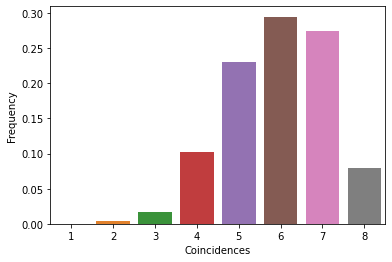

In [33]:
coinc_freq = pd.DataFrame(compare_predTest.Num_coinc.value_counts(normalize=True), index=[1,2,3,4,5,6,7,8])
coinc_freq.sort_index(inplace=True)
coinc_freq.fillna(0, inplace=True)
coinc_freq.columns = ["Frequency"]
coinc_freq['Coincidences'] = [1,2,3,4,5,6,7,8]
coinc_freq
sns.barplot(x="Coincidences", y="Frequency", data=coinc_freq)
plt.show()

In [34]:
# Really low accuracy score
rf_cl.score(X_test, y_test)

0.07888631090487239

To evaluate the performance of the Random forest classifier, it is compared with a **Dummy** classifier.
This dummy classifier predicts the outcomes based on frequency of each outcome (rows frequency). Hence, one classifier per outcome(column) (8 in total).

In [35]:
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier(strategy = 'stratified', random_state=0)
dclf.fit(X_train, y_train)
dcl_pred_raw = dclf.predict(X_test)
dcl_preds = pd.DataFrame(dcl_pred_raw,index=y_test.index ,columns=outcomes_cl.drop(['ids','MaxClass'], axis=1).columns)

In [36]:
# Dummy classifier accuracy is even lower.
print(dclf.score(X_test, y_test))

0.013921113689095127


In [37]:
compare_DCpredTest = (dcl_preds == y_test)
compare_DCpredTest['Num_coinc'] = compare_DCpredTest.sum(axis=1)

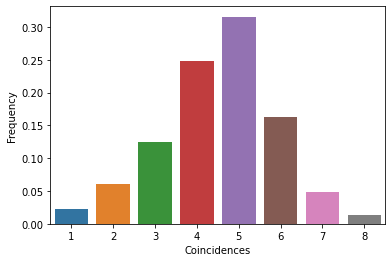

In [38]:
# This is the distribution of correct identities by the dummy classifier.
coinc_DCfreq = pd.DataFrame(compare_DCpredTest.Num_coinc.value_counts(normalize=True), index=[1,2,3,4,5,6,7,8])
coinc_DCfreq.sort_index(inplace=True)
coinc_DCfreq.fillna(0, inplace=True)
coinc_DCfreq.columns = ["Frequency"]
coinc_DCfreq['Coincidences'] = [1,2,3,4,5,6,7,8]
coinc_DCfreq
sns.barplot(x="Coincidences", y="Frequency", data=coinc_DCfreq)
plt.show()

**Random Forest vs. Dummy classifier**

Random Forest gets more gRNA regions with a higher percentage of correct predictions from the 8 labels. It gets all 8 outcomes classified as abundant/nonabundant correctly only for a 5% of targets. However, for most of the targets it gets about 5 to 7 outcomes from a total of 8 correctly classified, which is quite decent!

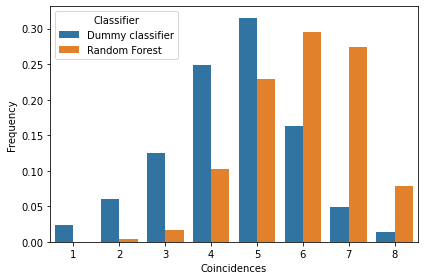

In [39]:
RFvDC = pd.DataFrame({'Coincidences':coinc_freq["Coincidences"],
                      'Dummy classifier':coinc_DCfreq["Frequency"],
                      'Random Forest':coinc_freq["Frequency"]})
RFvDC = pd.melt(RFvDC, id_vars=['Coincidences'], value_vars=['Dummy classifier','Random Forest'],
                var_name='Classifier', value_name='Frequency')
sns.barplot(x="Coincidences", y="Frequency", hue="Classifier", data=RFvDC)
plt.tight_layout()
plt.savefig("Approach2vsDummy.png", dpi=600)
plt.show()